In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

imports work


<span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data

In [5]:
run_number = 1093

hit_data = rf.get_ROOT_data_zip_RECO(run_number)

# print(len(hit_data))
# plane_7 = hit_data[hit_data.plane == 7]
# mask = ak.num(plane_7) == 1
# first_plane_starting_events = hit_data[mask]
# print(len(first_plane_starting_events))

1093 RECONSTRUCTED finished


<span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes

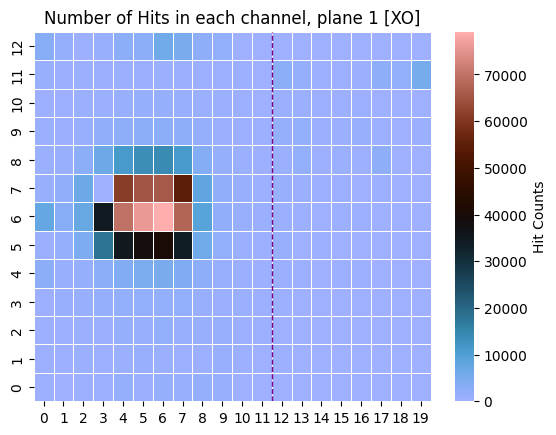

In [6]:
rf.hits_amount_colormap_single_plane(hit_data, 1)

<span style="font-family: arial; font-size:25px; color:pink">

Shower Evolution Throughout the Sensor

In [8]:
# rf.single_event_evolution_amp(hit_data, 441166, cmap="managua")

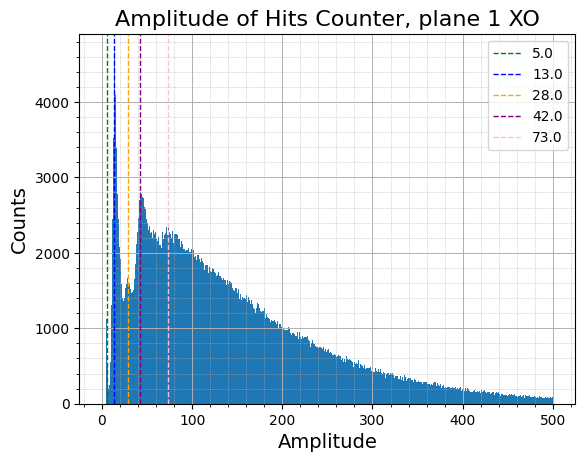

In [7]:
# plt.clf()   # Clear the current figure
# plt.close() # Close any open figures
# %matplotlib widget
rf.amp_histo_single_plane_total_event(hit_data,1)

amount of hits in plane 0: 475773
amount of hits in plane 1: 498272
amount of hits in plane 2: 497173
amount of hits in plane 3: 496904
amount of hits in plane 4: 498689
amount of hits in plane 5: 499149
amount of hits in plane 6: 497907
amount of hits in plane 7: 500186


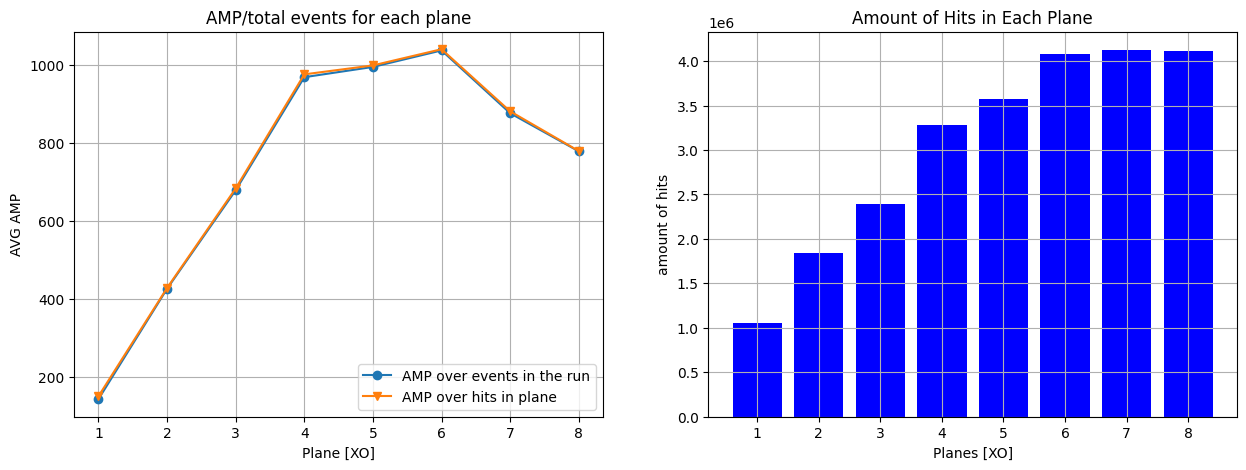

In [8]:
rf.average_amp_vs_plane(hit_data)

In [17]:
# rf.plot_empty_first_planes(hit_data)

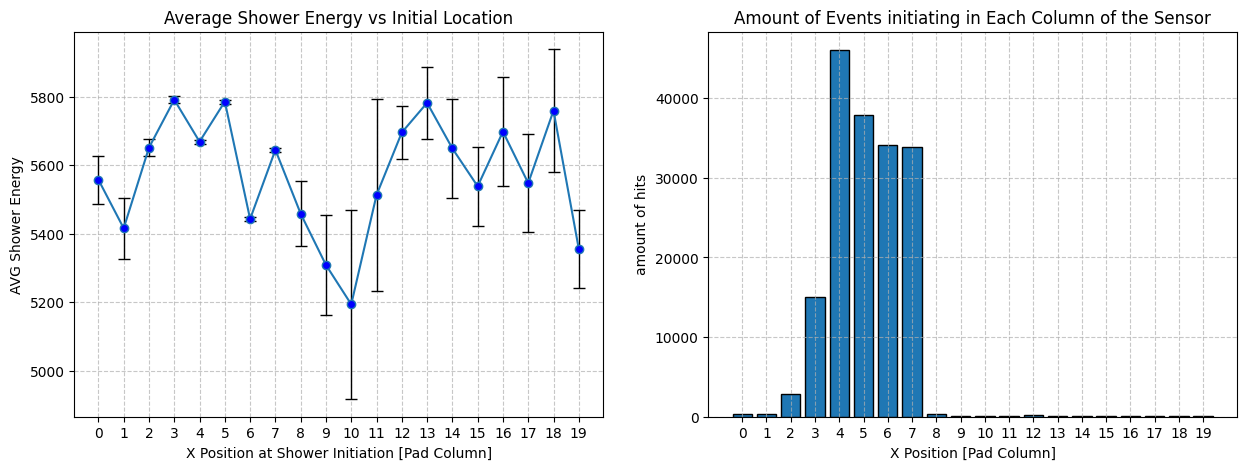

In [11]:
rf.event_shower_energy_vs_X_position(hit_data, single_pad_only="true")

3 15034
########
4 46050
########
5 37912
########
6 34144
########
7 33813
########


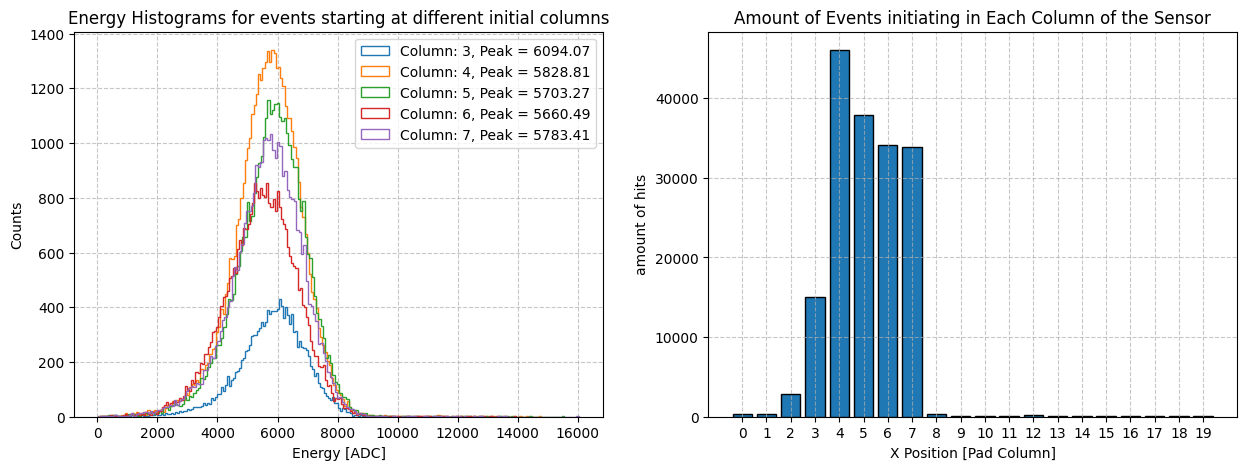

In [6]:
rf.Histo_shower_energy_for_X_position(hit_data, 5, single_pad_only = "true")

In [7]:
hit_data_with_distances = rf.Radii_from_Initial_position(hit_data)


In [8]:

def frac_energy_radii_histo(hit_data_with_distances, fraction_of_energy, calculate_R=False, bin_size = 0.5):

    if calculate_R:
        hit_data_with_distances = rf.Radii_from_Initial_position(hit_data_with_distances)

    R_at_frac = rf.frac_contained_energy_radius(hit_data_with_distances, fraction_of_energy)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    bins = np.arange(0, ak.max(R_at_frac) + bin_size, bin_size)
    counts, edges, patches = ax1.hist(R_at_frac, bins=bins, color='skyblue', edgecolor='black')

    ax1.set_xlabel("Radius [Pad Units]")
    ax1.set_ylabel("Counts")
    ax1.set_title(f"Radii containing {fraction_of_energy} of the energy in event")
    ax1.set_xticks(np.arange(0, np.max(R_at_frac) + 1, 1))
    ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

    ax1.yaxis.set_minor_locator(plt.MultipleLocator((ax1.get_yticks()[1] - ax1.get_yticks()[0]) / 2))
    ax1.grid(True, which='major', axis='y', linestyle='--', linewidth=0.8, alpha=0.7)
    ax1.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.6, alpha=0.5)

    # --- Secondary y-axis (percentages) ---
    ax2 = ax1.twinx()
    total = np.sum(counts)                # total number of events
    ax2.set_ylim(ax1.get_ylim())          # match limits to left axis
    ax2.set_ylabel("Percentage out of all events")

    # Find the maximum visible count on the left axis
    ymax = ax1.get_ylim()[1]

    # Create tick positions corresponding to 5% increments of *total counts*
    max_percent = 100 * ymax / total      # how far up the left axis goes in %
    percent_ticks = np.arange(0, max_percent + 5, 5)   # every 5% up to that value
    count_ticks = percent_ticks / 100 * total           # convert % back to counts

    # Apply these ticks and labels to the right axis
    ax2.set_yticks(count_ticks)
    ax2.set_yticklabels([f"{p:.0f}%" for p in percent_ticks])


    plt.tight_layout()
    plt.show()



In [9]:
hit_data_with_distances = rf.Radii_from_Initial_position(hit_data)


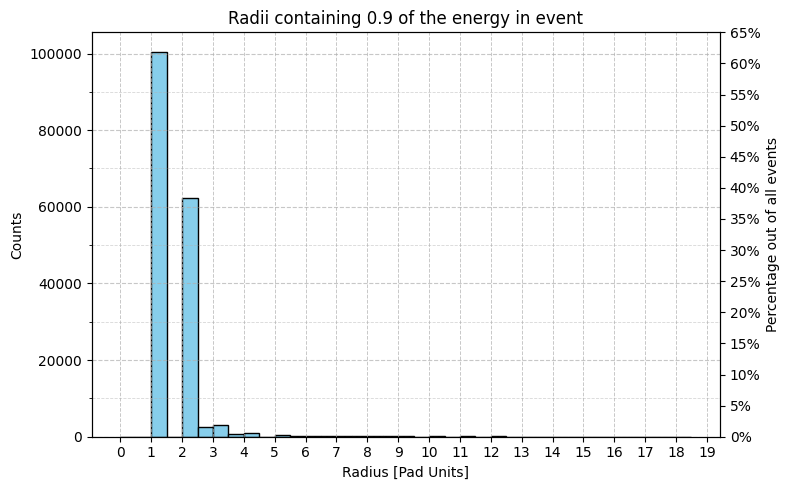

In [10]:
rf.frac_energy_radii_histo(hit_data_with_distances, 0.9)

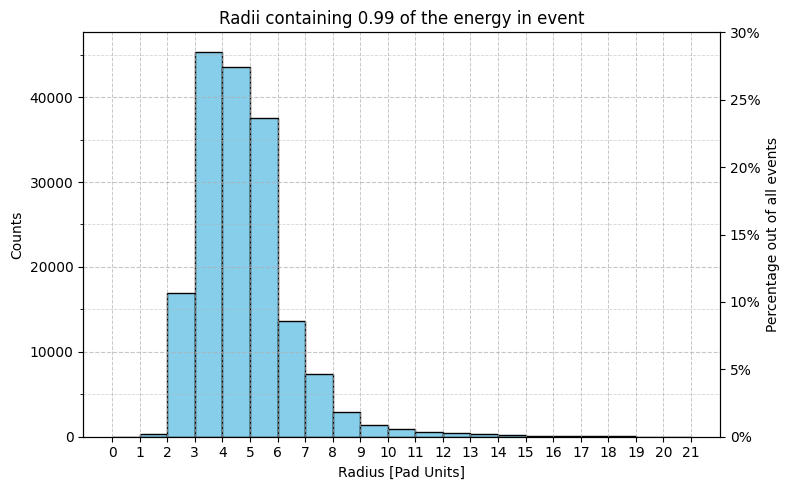

In [17]:
frac_energy_radii_histo(hit_data_with_distances, 0.99, bin_size = 1)

In [1]:
def event_shower_energy_vs_X_position(hit_data, single_pad_only = "false", specific_Y = "false"):
    
    # get only showers starting at the first plane to identify the initial location
    plane_7 = hit_data[hit_data.plane == 7]
    if single_pad_only == "false":
        mask = ak.num(plane_7) > 0

    if single_pad_only == "true":
        mask = ak.num(plane_7) == 1

    first_plane_starting_events = hit_data[mask]

    # determine the initial location of the shower
    # get the data on the first plane
    plane_7_clean = plane_7[mask]
    plane_7_channel = plane_7_clean.ch
    
    # get the x and y positions of each channel
    y, x = divmod(plane_7_channel, 20) #y is the quontinent and is the row, x is the remainder and column
    
    # make x and y one dimensional
    x_list = x.to_list()
    x_ak = ak.Array(x_list)
    x_avg = ak.mean(x_ak, axis = 1)

        
    # compute the shower energy for each event
    hit_amp_array = first_plane_starting_events.amp
    event_shower_amp_array = ak.sum(hit_amp_array, axis = 1)

    # calculate for a specific row if needed
    if specific_Y  != "false":
        y = ak.flatten(y)
        mask_Y = y == specific_Y
        x_avg = x_avg[mask_Y]
        event_shower_amp_array = event_shower_amp_array[mask_Y]

    # get the average shower energy for each X position
    div, avg_amps, classes = rf.ak_groupby(x_avg, event_shower_amp_array)
    
    # get the energies in all column (2d array)
    energies_per_column = div.data
    
    # get the statistics for each column
    means = ak.mean(energies_per_column, axis=1)
    sigmas = ak.std(energies_per_column, axis=1)

    # mean unsertinty
    sem = sigmas / np.sqrt(ak.num(energies_per_column, axis=1))

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot the energy avg per position vs the initial X position of the shower
    # ax1.plot(classes, avg_amps, marker='o')
    ax1.errorbar(
    classes, avg_amps, yerr=sem, fmt='-o',ecolor='black', elinewidth=1, capsize=4, capthick=1, markerfacecolor='blue', markersize=6, label='Data with error')

    ax1.set_xticks(np.arange(0, 20))
    ax1.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax1.set_xlabel('X Position at Shower Initiation [Pad Column]')
    ax1.set_ylabel('AVG Shower Energy')
    
    if specific_Y == "false":
        ax1.set_title('Average Shower Energy vs Initial Location')
    
    else:
        ax1.set_title(f'Average Shower Energy vs Initial Location, y = {specific_Y}')

    # show the amounnt of hits in each plane on a bar chart
    bins = np.arange(0, 21, 1) 
    ax2.hist(x_avg, bins=bins, edgecolor='black', rwidth=0.8)
    ax2.set_xticks(np.arange(0, 20) + 0.5)  # shift by 0.5
    ax2.set_xticklabels(np.arange(0, 20)) 
    ax2.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
    ax2.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel('X Position [Pad Column]')
    ax2.set_ylabel('amount of hits')
    ax2.set_title('Amount of Events initiating in Each Column of the Sensor')
    
    plt.show()




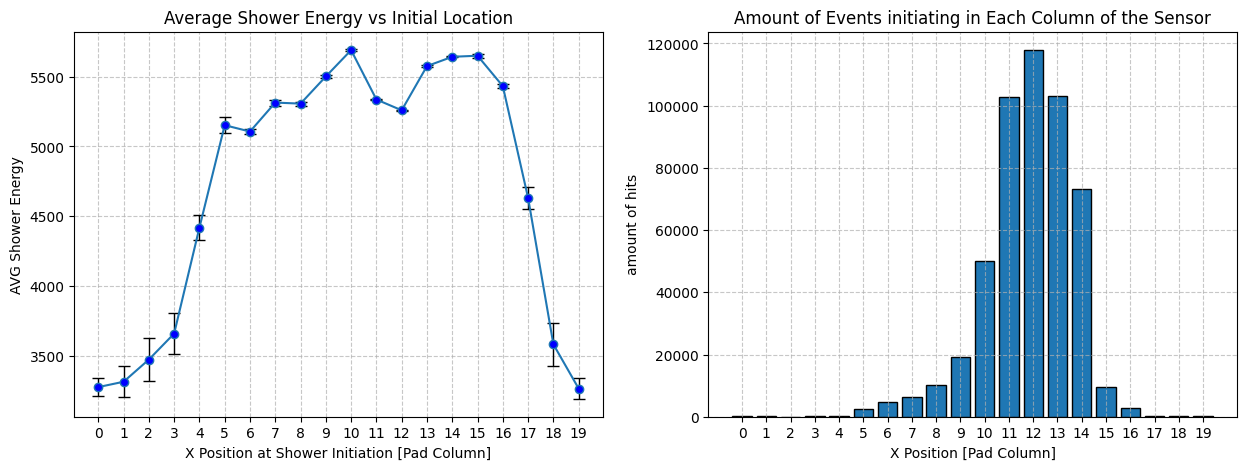

In [5]:
event_shower_energy_vs_X_position(hit_data)